<a href="https://colab.research.google.com/github/RealMyeong/Aiffel_Exploration/blob/main/EX_BS2_project10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 라이브러리 버전 확인

In [1]:
# !pip uninstall tensorflow
# !pip uninstall keras
# !pip install tensorflow==2.6.0
# !pip install keras==2.6.0

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re
import matplotlib.pyplot as plt


- 필요 데이터 불러옴

In [3]:
file_path = '/content/drive/MyDrive/AIFFEL/EX/10. 번역기/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


,eng,fra,cc
162586,He is by far the best player on the team.,Il est de loin le meilleur joueur de l'équipe.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
149952,The situation went from bad to worse.,La situation allait de pire en pire.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
43302,I'm sure Tom can win.,Je suis sûre que Tom peut gagner.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
40503,Did you volunteer us?,Nous as-tu désignés ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
144637,I'm going to go out and take a walk.,Je vais sortir faire un tour.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


- cc부분은 필요없고, 나중에 test셋은 3000개로 사용

In [4]:
lines = lines[['eng', 'fra']][:63000] 
lines.sample(5)

,eng,fra
60827,You have my permission.,Tu as ma permission.
18392,I don't allow it.,Je ne le permets pas.
30493,Is Tom from Boston?,Est-ce que Tom est de Boston ?
2829,Cover it up.,Camouflez-le.
22979,Go away. I'm busy.,Allez-vous-en. Je suis occupée.


## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

1. 구두점(Punctuation)을 단어와 분리
2. 문장을 소문자로 변경


In [5]:
lines_np_eng= lines['eng'].to_numpy()
lines_np_fra= lines['fra'].to_numpy()

문장을 소문자로 변경 후, 특수문자와 문자 사이에 공백을 넣어주는 함수 정의

In [6]:
sos_token = '<start> '
eos_token = ' <end>'

def preprocess_line(line, plus_token = True):
    # 소문자로 변경하기
    line = line.lower().strip()
    # 구두점(Punctuation)을 단어와 분리하기
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ", line)

    line = line.strip()
    
    if plus_token == True:
        line = sos_token + line + eos_token
    
    return line

띄어쓰기 단위로 토큰화 함수 정의

In [7]:
def tokenize(corpus):
    tokenizer = Tokenizer(
        num_words=9000,  
        filters=' ',   
        oov_token="<unk>"  
    )
    tokenizer.fit_on_texts(corpus)  

    tensor = tokenizer.texts_to_sequences(corpus)   

    return tensor, tokenizer

영어, 프랑스어 전처리하기


In [8]:
eng_lines = []
fra_lines = []

# eng_lines.append(lines.eng.apply(lambda x : preprocess_line(x,plus_token = False)))
# fra_lines.append(lines.fra.apply(lambda x : preprocess_line(x),))

for eng, fra in zip(lines.eng, lines.fra):
    if len(eng) == 0: continue
    if len(fra) == 0: continue   
        
    eng_lines.append(preprocess_line(eng, plus_token = False))
    fra_lines.append(preprocess_line(fra))

In [9]:
eng_tensor, eng_tokenizer = tokenize(eng_lines)
fra_tensor, fra_tokenizer = tokenize(fra_lines)
fra_tensor[:10]

[[2, 97, 21, 3],
 [2, 537, 4, 3],
 [2, 1086, 21, 3],
 [2, 1185, 21, 3],
 [2, 1185, 4, 3],
 [2, 658, 21, 3],
 [2, 2509, 21, 3],
 [2, 255, 192, 1343, 192, 4131, 21, 3],
 [2, 1296, 21, 3],
 [2, 3504, 21, 3]]

input, target 설정


In [10]:
encoder_input = eng_tensor
# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index['<end>']] for line in fra_tensor]
# 시작 토큰 제거
decoder_target =[[char for char in line if char != fra_tokenizer.word_index['<start>']] for line in fra_tensor]

padding 추가


In [11]:
def pad_tensor(tensor):
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = max(num_tokens)
    maxlen = int(max_tokens)
    tensor = pad_sequences(tensor, padding='post', maxlen=maxlen)  
    return tensor

In [12]:
encoder_input = pad_tensor(encoder_input)
decoder_input = pad_tensor(decoder_input)
decoder_target = pad_tensor(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (63000, 9)
프랑스어 입력데이터의 크기(shape) : (63000, 19)
프랑스어 출력데이터의 크기(shape) : (63000, 19)


In [13]:
eng_vocab_size = len(eng_tokenizer.word_index)+1
fra_vocab_size = len(fra_tokenizer.word_index)+1

max_eng_seq_len = encoder_input.shape[1]
max_fra_seq_len = decoder_input.shape[1]

In [14]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 63000
영어 단어장의 크기 : 6829
프랑스어 단어장의 크기 : 10556
영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 19


train, test dataset 나누기


In [15]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [16]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(60000, 9)
(60000, 19)
(60000, 19)
(3000, 9)
(3000, 19)
(3000, 19)


## Step 2. 임베딩 층(Embedding layer) 사용하여 모델 학습


In [17]:
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM, Dense
from tensorflow.keras.models import Model

embedding_size = 512
hidden_size = 512
# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout = 0.4, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [18]:
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout = 0.4, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [21]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    3496448     ['encoder_input[0][0]']          
                                                                                                  
 embedding_1 (Embedding)        (None, None, 512)    5404672     ['decoder_input[0][0]']          
                                                                                              

In [22]:
history = model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], 
                             decoder_target_test),
          batch_size=64, 
          epochs=20)

Epoch 1/20
938/938 [==============================] - 37s 28ms/step - loss: 1.3360 - val_loss: 1.0659
Epoch 2/20
938/938 [==============================] - 23s 25ms/step - loss: 0.9526 - val_loss: 0.8886
Epoch 3/20
938/938 [==============================] - 23s 25ms/step - loss: 0.8089 - val_loss: 0.7961
Epoch 4/20
938/938 [==============================] - 23s 24ms/step - loss: 0.7152 - val_loss: 0.7281
Epoch 5/20
938/938 [==============================] - 23s 25ms/step - loss: 0.6457 - val_loss: 0.6928
Epoch 6/20
938/938 [==============================] - 24s 25ms/step - loss: 0.5945 - val_loss: 0.6577
Epoch 7/20
938/938 [==============================] - 23s 25ms/step - loss: 0.5552 - val_loss: 0.6446
Epoch 8/20
938/938 [==============================] - 23s 25ms/step - loss: 0.5263 - val_loss: 0.6329
Epoch 9/20
938/938 [==============================] - 23s 25ms/step - loss: 0.5048 - val_loss: 0.6256
Epoch 10/20
938/938 [==============================] - 23s 25ms/step - loss: 0.481

In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'val_loss'])


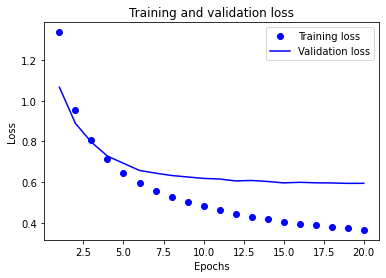

In [24]:

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, 21)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

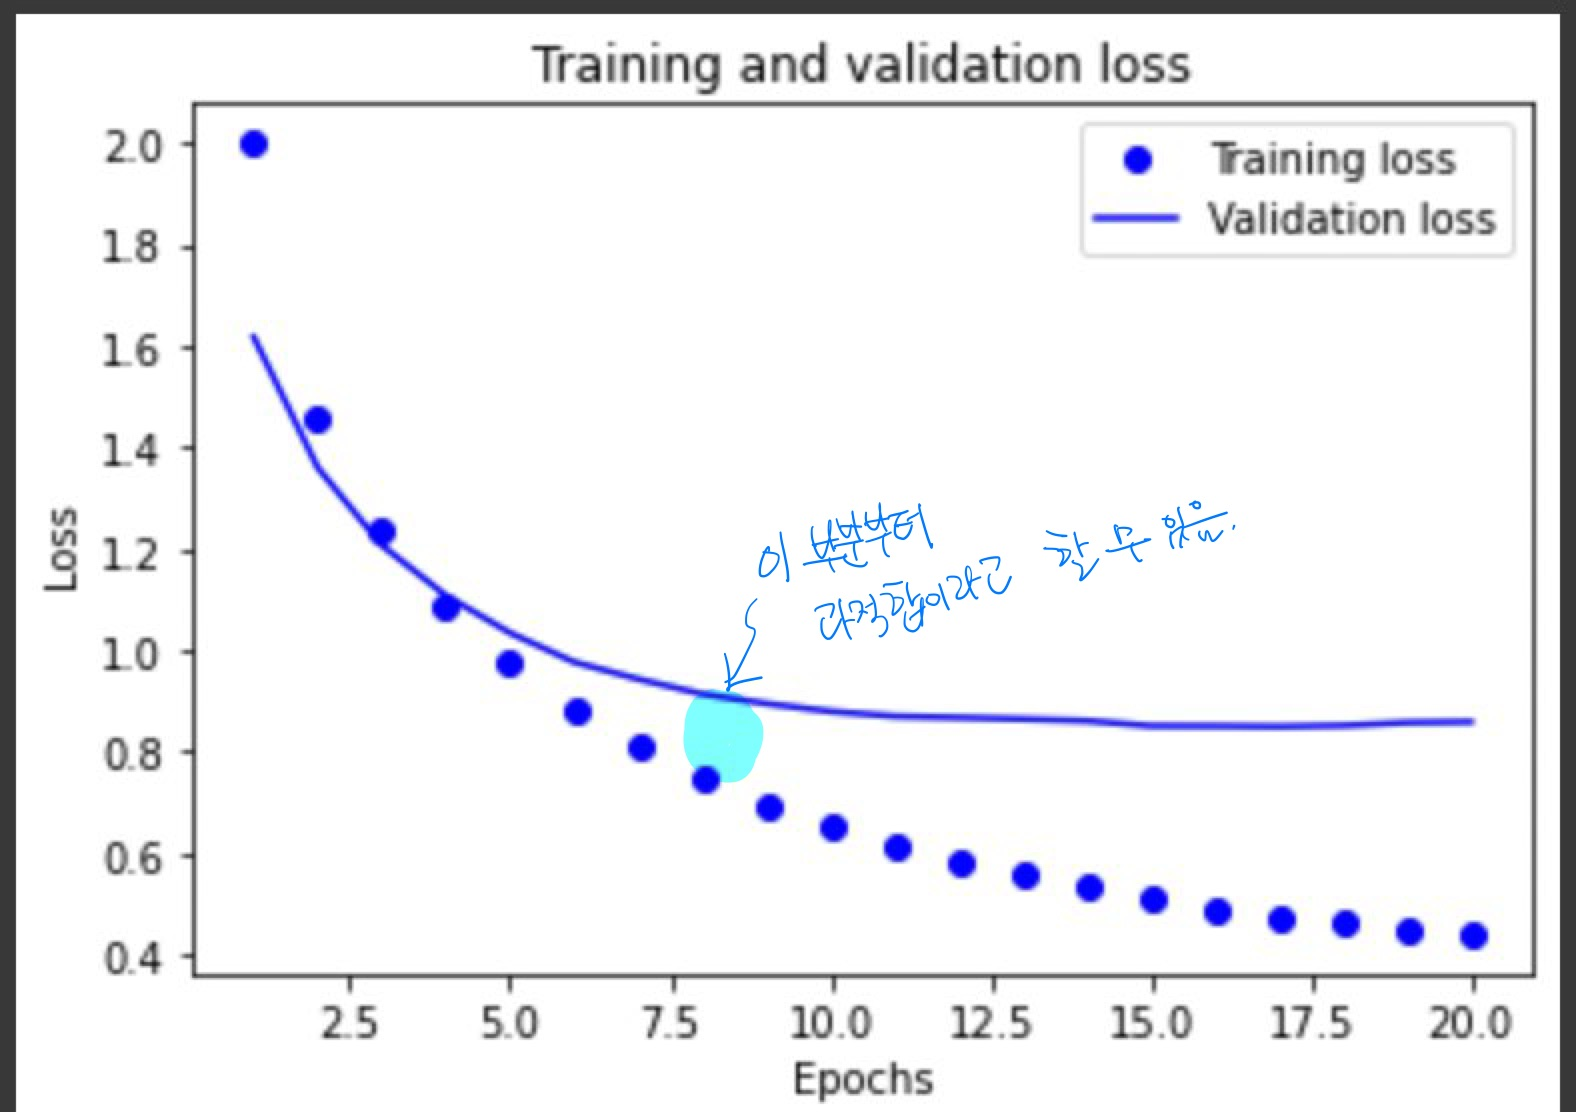

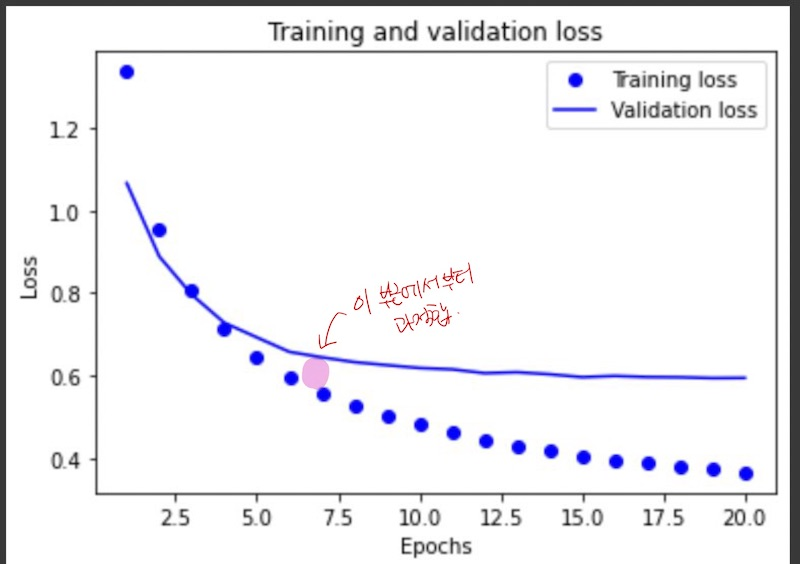

처음 모델 실행 돌리고 val loss와 train loss 그래프 그림이다.
epoch이 약 7-8 지점 부터 과적합 된다고 볼 수 있다.
dropout을 설정 해줬는데도 과적합이 되기 때문에 다른 방법을 고려해보는 것도 좋을 것 같다.

대표적으로 **훈련 데이터의 개수를 늘리는 방법**이 있지만.... 실제로 val loss는 처음보다 감소했지만 결국 과적합이 되기는 한다. 전과 비슷한 에폭에서. 학습이 너무 오래걸리기 때문에 일단은 epoch 7-8까지만 학습을 하는 방향으로 진행해야겠다. 

## Step 3. 모델 구현하기


- 인코더

In [25]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 512)         3496448   
                                                                 
 masking (Masking)           (None, None, 512)         0         
                                                                 
 lstm (LSTM)                 [(None, 512),             2099200   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 5,595,648
Trainable params: 5,595,648
Non-trainable params: 0
_________________________________________________________________


- 디코더

In [26]:
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [27]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [28]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 512)    5404672     ['decoder_input[0][0]']          
                                                                                                  
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

In [29]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [30]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [31]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

## Step 4. 모델 평가하기


In [32]:
for seq_index in [1,201,501,1004,2015]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: don t just stand there . 
정답 문장: ne restez pas plant es l ! 
번역기가 번역한 문장:  ne restez juste . 
-----------------------------------
입력 문장: what was it ? 
정답 문장: qu tait ce ? 
번역기가 번역한 문장:  qu tait ? ? ? ? ? 
-----------------------------------
입력 문장: i hated doing that . 
정답 문장: j ai d test faire a . 
번역기가 번역한 문장:  je d de le a a a . 
-----------------------------------
입력 문장: just ignore it . 
정답 문장: n y pr te simplement pas attention ! 
번역기가 번역한 문장:  n n le tout . ! ! 
-----------------------------------
입력 문장: i ve checked . 
정답 문장: j ai v rifi . 
번역기가 번역한 문장:  j v . . . . . . . 


# 토큰화 다른 방식으로 진행한 부분

In [33]:
def preprocess_sentence(s):
  s = s.lower().strip() #1 문장을 소문자로 바꾸고 양쪽 공백을 지움
  s = re.sub(r"([?.!,¿])", r" \1", s) #2 특수 문자 양쪽에 공백을 넣음
  s = re.sub(r'[" "]+', " ", s) #3 여러개의 공백을 하나의 공백으로 바꿈
  s = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', s) #4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿈
  s = s.strip() #5 양쪽 공백을 지움
  return s

In [34]:
#각각의 컬럼들을 리스트로 저장
eng_list = list(lines['eng'])
fra_list = list(lines['fra'])

In [35]:
#각 리스트에 있는 문장들 전처리
preprocess_eng_list = []
preprocess_fra_list = []

for s in eng_list:
  s = preprocess_sentence(s)
  preprocess_eng_list.append(s)

for s in fra_list:
  s = preprocess_sentence(s)
  preprocess_fra_list.append(s)

In [36]:
# 전처리 잘 됐는지 확인
print(len(preprocess_eng_list), preprocess_eng_list[6333])
print(len(preprocess_fra_list), preprocess_fra_list[6222])

63000 what a night !
63000 nous avons toutes pleur .


3. 디코더 문장에 시작 토큰과 종료 토큰 추가

In [37]:
data = pd.DataFrame(zip(preprocess_eng_list, preprocess_fra_list),  columns = ['eng', 'fra'])
data.sample(5)

,eng,fra
30811,it s something new .,c est quelque chose de nouveau .
40951,get in the back seat .,mettez vous dans le si ge de derri re .
15294,no one answered .,personne n a r pondu .
33392,you aren t smiling .,vous ne souriez pas .
31074,no one can hear us .,personne ne peut nous entendre .


In [38]:
# 시작 토큰과 종료 토큰 추가
sos_token = '<start>'
eos_token = '<end>'
data.fra = data.fra.apply(lambda x : '<start> '+ x + ' <end>')
print('전체 샘플의 수 :',len(data))
data.sample(5)

전체 샘플의 수 : 63000


,eng,fra
36078,i think you re cute .,<start> je pense que vous tes adorables . <end>
14395,i want that bag .,<start> je veux ce sac . <end>
23974,i love your dress .,<start> j adore votre robe . <end>
23783,i have to go home .,<start> je dois rentrer chez moi . <end>
6708,could we walk ?,<start> pourrions nous marcher ? <end>


- eng, fra 토큰화 

In [39]:
eng_list = list(data['eng'])
fra_list = list(data['fra'])

eng_token = []
fra_token = []

for i in eng_list:
  a = i.split()
  eng_token.append(a)

for i in fra_list:
  a = i.split()
  fra_token.append(a)

In [40]:
print(eng_token[16666])
print(fra_token[16666])

['we', 're', 'too', 'close', '.']
['<start>', 'nous', 'sommes', 'trop', 'proches', '.', '<end>']


In [41]:
lines_np_eng= np.array(eng_token, dtype=object)
lines_np_fra= np.array(fra_token, dtype=object)

## Step 2. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.





문자를 모두 인덱스로 바꿈

In [42]:
eng_tokenizer = Tokenizer()

# fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성.
eng_tokenizer.fit_on_texts(lines_np_eng) 
input_text = eng_tokenizer.texts_to_sequences(lines_np_eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[16666]

[14, 13, 75, 263, 1]

In [43]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines_np_fra)
target_text = fra_tokenizer.texts_to_sequences(lines_np_fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 96, 20, 2], [1, 536, 3, 2], [1, 1085, 20, 2]]

In [44]:
print(type(eng_tokenizer.texts_to_sequences(eng_token)))

<class 'list'>


- input, output으로 숫자로 바꾼 것들을 할당


- 단어장 크기 저장

In [45]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 6830
프랑스어 단어장의 크기 : 10557


- 최대 길이 구함

In [46]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 20


In [47]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 63000
영어 단어장의 크기 : 6830
프랑스어 단어장의 크기 : 10557
영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 20


## Step 3. 임베딩 층(Embedding layer) 사용하기


In [48]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

종료 토큰에 해당하는 숫자2와 시작 토큰에 해당하는 숫자1이 각각 디코더의 인풋과 아웃풋에서 사라진것을 볼 수 있다. 

In [49]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 96, 20], [1, 536, 3], [1, 1085, 20]]
[[96, 20, 2], [536, 3, 2], [1085, 20, 2]]


- 패딩으로 길이 맞춰줌

In [50]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (63000, 9)
프랑스어 입력데이터의 크기(shape) : (63000, 20)
프랑스어 출력데이터의 크기(shape) : (63000, 20)


In [51]:
print((encoder_input))

[[33  1  0 ...  0  0  0]
 [33  1  0 ...  0  0  0]
 [33  1  0 ...  0  0  0]
 ...
 [ 2 24 10 ...  7  1  0]
 [ 2 24 10 ...  5  1  0]
 [ 2 24 10 ...  3  1  0]]


- 33000데이터 중 3000개 테스트, 30000개 학습

In [52]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [53]:

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(60000, 9)
(60000, 20)
(60000, 20)
(3000, 9)
(3000, 20)
(3000, 20)


- 인코더 설계

In [54]:
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM, Dense
from tensorflow.keras.models import Model

# 입력 텐서 생성.
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, 128, input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [55]:
enc_masking.shape

TensorShape([None, None, 128])

- 디코더 설계

In [56]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, 128)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

- 디코더 출력층 설계

In [57]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [58]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 128)    874240      ['input_3[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, None, 128)    1351296     ['input_4[0][0]']                
                                                                                            

In [59]:
model.fit(x=[encoder_input_train, decoder_input_train],
          y=decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], 
                             decoder_target_test),
          batch_size=64, epochs=50)

Epoch 1/50


ValueError: ignored

## 회고

### 1차 예측 번역 결과


입력 문장: i think you must be tired .   
정답 문장: je pense que tu dois tre fatigu .   
번역기가 번역한 문장:  je je que que qu  

입력 문장: i m in charge of shopping .   
정답 문장: je suis responsable des courses .   
번역기가 번역한 문장:  je me de je je .   

입력 문장: he was humiliated by her .  
정답 문장: elle l <unk> .  
번역기가 번역한 문장:  il l t . . . . .  

입력 문장: it s a good way to learn .  
정답 문장: c est une bonne fa on d apprendre .  
번역기가 번역한 문장:  c de bien bien d  

입력 문장: you aren t as short as me .  
정답 문장: tu n es pas aussi petite que moi .  
번역기가 번역한 문장:  vous n tes vous vou  

### 2차 번역

입력 문장: don t just stand there .   
정답 문장: ne restez pas plant es l !   
번역기가 번역한 문장:  ne restez juste .   

입력 문장: what was it ?   
정답 문장: qu tait ce ?   
번역기가 번역한 문장:  qu tait ? ? ? ? ?   

입력 문장: i hated doing that .   
정답 문장: j ai d test faire a .   
번역기가 번역한 문장:  je d de le a a a .   

입력 문장: just ignore it .   
정답 문장: n y pr te simplement pas attention !   
번역기가 번역한 문장:  n n le tout . ! !   

입력 문장: i ve checked .   
정답 문장: j ai v rifi .   
번역기가 번역한 문장:  j v . . . . . . .   

### 회고

처음에 토큰화 부분에서 이 전의 네이버 리뷰 분석에서 했던 토큰화 방법을 사용하지 않고 다른 방법으로 해보려고 데이터에서 column을 리스트로 받아와서 따로 토큰화를 해줬다. 근데 그 리스트로 받아오는 부분부터 문제가 생겼는지는 모르겠지만 모델을 fit하는 부분에서 계속 에러가 났다. 그래서 결국은 네이버 리뷰 분석에서 썼던 토큰화 방법을 사용해서 진행을 하긴 했는데 솔직히 뭐가 문젠지는 모르겠다 ㅎ 

  처음엔 리스트로 받아오는 부분이 문제라 생각해서 토큰화 진행후에 np.array에 넣어서 넘파이로 바꿔줬는데 그래도 오류가 났다... 코드를 뜯어 봤을때는 토큰화 부분 말고는 다른 부분이 전혀 보이지 않는데 뭐가 문제인가 싶다 정말로...내가 못찾았을수도 있지만 ㅎㅎ

그리고 번역 결과가 생각보다 좋지 않은데, 실제로 그래프를 보면 과적합이 생각보다 빨리 온다. 50에폭을 돌려도 한 8에폭 정도에서 과적합이 되는데 데이터를 늘리고, dropout층 추가, 다양한 전처리 방법을 통해 진행하면 성능을 좀 더 높일 수 있을 것 같다. 

